# SNN_0

This code is designed to demo the use of a Spiking Neural Network to propogate spikes between neurons. At this stage there is no learning involved, it's purely about propogating spikes between LIF neurons.

More biologically plausible neurons and learning will be introduced later.

### Set up the environment

In [1]:
import numpy as np
from mnist import MNIST   
import cv2
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
duration = 50        # Length of each time period (ms)

### Utility functions

In [3]:
def plot_neuron_behaviour(time, data, neuron_type, neuron_id, y_title):
    #print ('Drawing graph with time.shape={}, data.shape={}'.format(time.shape, data.shape))
    plt.plot(time,data)
    plt.title('{} @ {}'.format(neuron_type, neuron_id))
    plt.ylabel(y_title)
    plt.xlabel('Time (msec)')
    plt.ylim([0,2])
    plt.show()

In [4]:
def plot_membrane_potential(time, Vm, neuron_type, neuron_id = 0):
    plot_neuron_behaviour(time, Vm, neuron_type, neuron_id, y_title = 'Membrane potential (V)')

def plot_spikes(time, Vm, neuron_type, neuron_id = 0):
    plot_neuron_behaviour(time, Vm, neuron_type, neuron_id, y_title = 'Spike (V)')

### Create a basic neuron class

Use LIF neuron for now, this can be made more complex over time.

Based on http://neurdon.wpengine.com/2011/01/19/neural-modeling-with-python-part-1/

In [12]:
class Neuron():
    def __init__(self):
        # Simulation config (may not all be needed!!)
        self.dt       = 0.125       # simulation time step
        self.t_rest   = 0           # initial refractory time
        
        #LIF Properties 
        self.Vm       = 0                # Initial potential (mV)
        self.output   = 0                # Neuron output
        self.t        = 0                # Neuron time step
        self.Rm       = 1                # Resistance (kOhm)
        self.Cm       = 10               # Capacitance (uF)
        self.tau_m    = self.Rm * self.Cm # Time constant
        self.tau_ref  = 4                # refractory period (ms)
        self.Vth      = 0.75             # = 1  #spike threshold
        self.V_spike  = 0.5              # spike delta (V)
        self.type     = 'Leaky Integrate and Fire'
        self.debug    = True
        if self.debug:
            print ('Neuron(): Created {} neuron starting at time {}'.format(self.type, self.t))
    
    def spike_generator(self, neuron_input):
        duration = len(neuron_input)
        if self.debug:
            print ('spike_generator(): Running time period self.t={}, self.t+duration={}'.format(self.t, self.t+duration))
        time = np.arange(self.t, self.t+duration)       
        Vm = np.zeros(duration)  #len(time)) # potential (V) trace over time
        output = np.zeros(duration)  #len(time))
        Vm[-1] = self.Vm   # Vm[0] doesn't work due to the equation below starting with [i-1] when i=0
        if self.debug:
            print ('Neuron.spike_generator.initial_state(input={}, duration={}, Vm={}, t={})'
               .format(neuron_input, duration, self.Vm, self.t))
        #for i,t in enumerate(time):
        for i in range(duration):
            t = self.t   # Hacky!! 
            if t > self.t_rest:
                Vm[i] = Vm[i-1] + (-Vm[i-1] + neuron_input[i-1]*self.Rm) / self.tau_m * self.dt
                if self.debug:
                    print('spike_generator(): i={}, t={}, Vm[i-1]={}, neuron_input={}, self.Rm={}, self.tau_m * self.dt = {}'
                          .format(i,t, Vm[i-1], neuron_input[i-1], self.Rm, self.tau_m * self.dt))
                if Vm[i] >= self.Vth:
                    #Vm[i] += self.V_spike
                    output[i] = 1
                    self.t_rest = t + self.tau_ref
                    if self.debug:
                        print ('*** Neuron.spike_generator.spike=(self.t_rest={}, t={}, self.tau_ref={})'
                           .format(self.t_rest, t, self.tau_ref))

            # Save state
            self.Vm = Vm[i]
            self.output = output[i]
            self.t += self.dt
        if self.debug:
            print ('Neuron.spike_generator.exit_state(Vm={} at iteration i={}, time={})'
                   .format(self.Vm, i, self.t))
        return time, Vm, output

* Assume a consistent/single input value for now

In [13]:
T         = 20    # total time to sumulate (msec)
dt        = 0.0125 # Simulation timestep
time      = int(T / dt)
inpt      = 0.9   # Neuron input voltage
neuron_input=np.full((time),inpt)

In [14]:
print('input: time={}'.format(time))

input: time=1600


In [15]:
neuron = Neuron()

Neuron(): Created Leaky Integrate and Fire neuron starting at time 0


In [16]:
neuron_time = np.zeros(1)
neuron_Vm = np.zeros(1)
neuron_output = np.zeros(1)
#for time_step in range (5):
t, v, o = neuron.spike_generator(neuron_input)
neuron_time = np.append(neuron_time,t)
neuron_Vm = np.append(neuron_Vm,v)
neuron_output = np.append(neuron_output, o)
    

spike_generator(): Running time period self.t=0, self.t+duration=1600
Neuron.spike_generator.initial_state(input=[ 0.9  0.9  0.9 ...,  0.9  0.9  0.9], duration=1600, Vm=0, t=0)
spike_generator(): i=1, t=0.125, Vm[i-1]=0.0, neuron_input=0.9, self.Rm=1, self.tau_m * self.dt = 1.25
spike_generator(): i=2, t=0.25, Vm[i-1]=0.01125, neuron_input=0.9, self.Rm=1, self.tau_m * self.dt = 1.25
spike_generator(): i=3, t=0.375, Vm[i-1]=0.022359375, neuron_input=0.9, self.Rm=1, self.tau_m * self.dt = 1.25
spike_generator(): i=4, t=0.5, Vm[i-1]=0.0333298828125, neuron_input=0.9, self.Rm=1, self.tau_m * self.dt = 1.25
spike_generator(): i=5, t=0.625, Vm[i-1]=0.044163259277343755, neuron_input=0.9, self.Rm=1, self.tau_m * self.dt = 1.25
spike_generator(): i=6, t=0.75, Vm[i-1]=0.05486121853637696, neuron_input=0.9, self.Rm=1, self.tau_m * self.dt = 1.25
spike_generator(): i=7, t=0.875, Vm[i-1]=0.06542545330467225, neuron_input=0.9, self.Rm=1, self.tau_m * self.dt = 1.25
spike_generator(): i=8, t=1.0, Vm

In [17]:
print (neuron_time.shape)

(1601,)


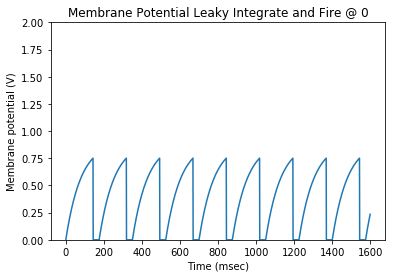

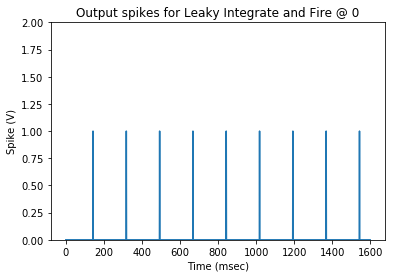

In [18]:
plot_membrane_potential(neuron_time, neuron_Vm, 'Membrane Potential {}'.format(neuron.type), neuron_id = "0")
plot_spikes(neuron_time, neuron_output, 'Output spikes for {}'.format(neuron.type), neuron_id = "0")

In [19]:
neuron2 = Neuron()

Neuron(): Created Leaky Integrate and Fire neuron starting at time 0


In [20]:
#neuron2_time = np.zeros(len(neuron_time))
#print (neuron2_time.shape)
#neuron2_Vm = np.zeros(len(neuron_Vm))
#print (neuron2_Vm.shape)
#neuron2_output = np.zeros(len(neuron_output))
#print (neuron2_output.shape)

In [21]:
neuron2_input = neuron_output
#print (neuron2_input.shape)
#neuron2_time = np.zeros(len(neuron_time))
#neuron2_Vm = np.zeros(len(neuron_Vm))
#neuron2_output = np.zeros(len(neuron_output))

In [23]:
neuron2_time, neuron2_Vm, neuron2_output = neuron2.spike_generator(neuron2_input)   #[time_step], duration=0.25)
#neuron2_time = np.append(neuron2_time,t)
#neuron2_Vm = np.append(neuron2_Vm,v)
#neuron2_output = np.append(neuron2_output, o)

spike_generator(): Running time period self.t=200.0, self.t+duration=1801.0
Neuron.spike_generator.initial_state(input=[ 0.  0.  0. ...,  0.  0.  0.], duration=1601, Vm=0.23452305749549993, t=200.0)
spike_generator(): i=0, t=200.0, Vm[i-1]=0.23452305749549993, neuron_input=0.0, self.Rm=1, self.tau_m * self.dt = 1.25
spike_generator(): i=1, t=200.125, Vm[i-1]=0.23159151927680618, neuron_input=0.0, self.Rm=1, self.tau_m * self.dt = 1.25
spike_generator(): i=2, t=200.25, Vm[i-1]=0.2286966252858461, neuron_input=0.0, self.Rm=1, self.tau_m * self.dt = 1.25
spike_generator(): i=3, t=200.375, Vm[i-1]=0.22583791746977303, neuron_input=0.0, self.Rm=1, self.tau_m * self.dt = 1.25
spike_generator(): i=4, t=200.5, Vm[i-1]=0.22301494350140086, neuron_input=0.0, self.Rm=1, self.tau_m * self.dt = 1.25
spike_generator(): i=5, t=200.625, Vm[i-1]=0.22022725670763335, neuron_input=0.0, self.Rm=1, self.tau_m * self.dt = 1.25
spike_generator(): i=6, t=200.75, Vm[i-1]=0.21747441599878795, neuron_input=0.0, 

In [51]:
start_time = 0
end_time = len(neuron_time)
print(start_time,end_time)

0 1601


In [53]:
print (neuron2_time.shape)
print (neuron2_time)

(1601,)
[  400.125   401.125   402.125 ...,  1998.125  1999.125  2000.125]


Drawing graph with time.shape=(1601,), data.shape=(1601,)


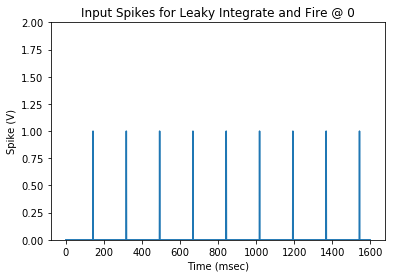

Drawing graph with time.shape=(1601,), data.shape=(1601,)


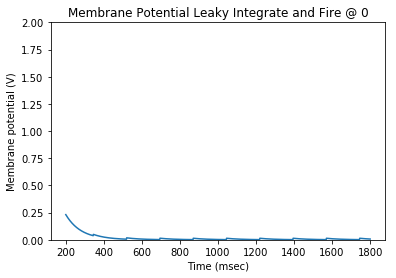

Drawing graph with time.shape=(1601,), data.shape=(1601,)


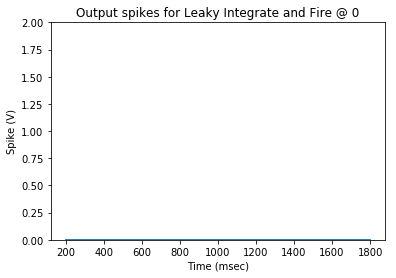

In [44]:
plot_spikes(neuron_time[start_time:end_time], neuron_output[start_time:end_time], 
            'Input Spikes for {}'.format(neuron2.type), neuron_id = "0")
plot_membrane_potential(neuron2_time[start_time:end_time], neuron2_Vm[start_time:end_time], 
            'Membrane Potential {}'.format(neuron2.type), neuron_id = "0")
plot_spikes(neuron2_time[start_time:end_time], neuron2_output[start_time:end_time], 
            'Output spikes for {}'.format(neuron2.type), neuron_id = "0")

In [ ]:
print(neuron2_time[start_time:end_time])

In [ ]:
plot_spikes(neuron_time, neuron_output, neuron2.type, neuron_id = "0")
plot_membrane_potential(neuron2_time, neuron2_Vm, neuron2.type, neuron_id = "0")
plot_spikes(neuron2_time, neuron2_output, neuron2.type, neuron_id = "0")

In [ ]:
print(len(neuron_time))
print((neuron2_time))
print(len(neuron2_Vm))
print(len(neuron2_output))